# __Data Cleaning__

### Introduction

We are given a dataset that contains 12,795 observations of different wines. Each observation contains key metrics that describe the wine's chemical makeup. We're also given a "STARS" variable which is a subjective expert quality ranking for each wine, and "LabelAppeal" which indicates the level of marketability for that brand of wine. Finally, we're given a "target" feature which represents the number of cases sold of each particular wine. This is going to be our response variable in this excercise. We want to build a model that can predict the cases sold based on the other metrics. However, the data contains numerous inaccuracies and missing data.

__Goal:__ Analyze and clean the data to the point that it's useable in a machine learning model.

## Variables

| Data Set Attribute  | Description | Data Type |Range |
|:--------------------|:----------- |:--------- |:---- |
|__Index__| Unique ID for each observarion|Numeric/Discrete|0 - 12,795|
|__TARGET__|Response Variable (indicates # of cases of wine sold)|Numeric/Ordinal|0-8|
|__FixedAcidity__|FixedAcidity of the wine (g/L)|Numeric/Continuous|-18.1 - 34.4|
|__VolatileAcidity__|Volatile acid content of the wine (g/L)|Numeric/Continuous|-2.79 - 3.68|
|__CitricAcid__|Citric Acid content of the wine (g/L)|Numeric/Continuous|-3.24 - 3.86|
|__ResidualSugar__|Residual sugar content of the wine (g/L)|Numeric/Continuous|-127.8 - 141.15|
|__Chlorides__ |Chloride content of the wine (g/L)|Numeric/Continuous|-1.171 - 1.351|
|__FreeSulfurDioxide__ |Sulfur Dioxide content of the wine (mg/L)|Numeric/Continuous|-555 - 623|
|__TotalSulfurDioxide__|Total sulfur dioxide content of the wine (mg/L)|Numeric/Continuous|-823 - 1057|
|__Density__ |Density of the wine (g/mL)|Numeric/Continuous|0.888 - 1.009|
|__pH__|pH of the wine|Numeric/Continuous|0.48 - 6.13|
|__Sulphates__|Sulfate content of the wine|Numeric/Continuous|-3.13 - 4.24|
|__Alcohol__|Alcohol Content|Numeric/Continuous|-4.7 - 26.5|
|__LabelAppeal__|Subjective marketing score that indicates the appeal of the design of the label on the bottle|Categorical/Ordinal|-2 - 2|
|__AcidIndex__|Measures total acidity of wine via a weighted average|Numeric/Continuous|4 - 17|
|__STARS__|Wine rating as determined by experts (4 = excellent; 1 = Poor)|Categorical/Ordinal|1 - 4|


## __1. Import libraries and read data__

First, we're going to import the necessary libraries and load the data csv into a Pandas data frame.

In [301]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
import numpy as np
from pandas.plotting import scatter_matrix
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [302]:
# load data into df
wine_data = pd.read_csv("https://raw.githubusercontent.com/thesabermaniac/DataCleaning/main/Day2_Data.csv")

wine_data_copy = wine_data.copy()

# get snapshot of data
wine_data.head()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0


## __2. Exploratory Data Analysis__

Next, we're going to do a deeper dive into the data to get a better picture of what we're dealing with.

First, we check the shape of the data. This returns the number of columns and rows present in our dataset.

In [303]:
wine_data.shape

(12795, 16)

We have 12,795 rows (observations) and 16 columns (features) in our dataset

Next, we run `.describe()` on our data frame to get all the key metrics for our dataset

In [304]:
wine_data.iloc[:,1:].describe()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
count,12795.000000,12795.000000,12795.000000,12795.000000,12179.000000,12157.000000,12148.000000,12113.000000,12795.000000,12400.000000,11585.000000,12142.000000,12795.000000,12795.000000,9436.000000
mean,3.029074,7.075717,0.324104,0.308413,5.418733,0.054822,30.845571,120.714233,0.994203,3.207628,0.527112,10.489236,-0.009066,7.772724,2.041755
std,1.926368,6.317643,0.784014,0.862080,33.749379,0.318467,148.714558,231.913211,0.026538,0.679687,0.932129,3.727819,0.891089,1.323926,0.902540
min,0.000000,-18.100000,-2.790000,-3.240000,-127.800000,-1.171000,-555.000000,-823.000000,0.888090,0.480000,-3.130000,-4.700000,-2.000000,4.000000,1.000000
25%,2.000000,5.200000,0.130000,0.030000,-2.000000,-0.031000,0.000000,27.000000,0.987720,2.960000,0.280000,9.000000,-1.000000,7.000000,1.000000
50%,3.000000,6.900000,0.280000,0.310000,3.900000,0.046000,30.000000,123.000000,0.994490,3.200000,0.500000,10.400000,0.000000,8.000000,2.000000
75%,4.000000,9.500000,0.640000,0.580000,15.900000,0.153000,70.000000,208.000000,1.000515,3.470000,0.860000,12.400000,1.000000,8.000000,3.000000
max,8.000000,34.400000,3.680000,3.860000,141.150000,1.351000,623.000000,1057.000000,1.099240,6.130000,4.240000,26.500000,2.000000,17.000000,4.000000


As you can see, we have many negative numbers in columns that should be zero bound (can't go below zero). Let's take a closer look at that

#### Negatives

Let's take a closer look at those negatives numbers

In [305]:
negatives = wine_data.where(wine_data<0).count()
negatives

INDEX                    0
TARGET                   0
FixedAcidity          1621
VolatileAcidity       2827
CitricAcid            2966
ResidualSugar         3136
Chlorides             3197
FreeSulfurDioxide     3036
TotalSulfurDioxide    2504
Density                  0
pH                       0
Sulphates             2361
Alcohol                118
LabelAppeal           3640
AcidIndex                0
STARS                    0
dtype: int64

There are 10 columns that contain negative numbers, with LabelAppeal containing the largest sum of negatives at 3,640. Almost all of these categories should be zero bound, meaning they shouldn't go below 0.

Let's see the percentage of negatives for each column.

In [306]:
neg_pct = wine_data.where(wine_data<0).count()/wine_data.count() * 100
neg_pct.sort_values(inplace=True, ascending=False)
neg_pct

LabelAppeal           28.448613
Chlorides             26.297606
ResidualSugar         25.749240
FreeSulfurDioxide     24.991768
CitricAcid            23.180930
VolatileAcidity       22.094568
TotalSulfurDioxide    20.672005
Sulphates             20.379801
FixedAcidity          12.669011
Alcohol                0.971833
STARS                  0.000000
AcidIndex              0.000000
pH                     0.000000
Density                0.000000
TARGET                 0.000000
INDEX                  0.000000
dtype: float64

As you can see, the negative data makes up a significant portion of our dataset. Thus, we can't simply delete all rows containing negatives becuase it would cause us to lose a significant amount of useable data.

#### Null Values

Let's see if there is any missing data in our dataset by checking the null values

In [307]:
wine_data.isnull().sum()

INDEX                    0
TARGET                   0
FixedAcidity             0
VolatileAcidity          0
CitricAcid               0
ResidualSugar          616
Chlorides              638
FreeSulfurDioxide      647
TotalSulfurDioxide     682
Density                  0
pH                     395
Sulphates             1210
Alcohol                653
LabelAppeal              0
AcidIndex                0
STARS                 3359
dtype: int64

It looks like there is a significant amount of missing data, especially in the "STARS" column. Let's see what percentage of the data these nulls make up.

In [308]:
# percentage of missing data
missing = wine_data.isnull().mean() * 100
missing.sort_values(inplace=True, ascending=False)
missing

STARS                 26.252442
Sulphates              9.456819
TotalSulfurDioxide     5.330207
Alcohol                5.103556
FreeSulfurDioxide      5.056663
Chlorides              4.986323
ResidualSugar          4.814381
pH                     3.087143
AcidIndex              0.000000
LabelAppeal            0.000000
Density                0.000000
CitricAcid             0.000000
VolatileAcidity        0.000000
FixedAcidity           0.000000
TARGET                 0.000000
INDEX                  0.000000
dtype: float64

More than a quarter of the "STARS" column is null and significant percentages of other categories are missing as well. This means we likely can't just drop the rows without losing valuable usable data.

Here's visualaztion of our missing data. This makes it easier to see how significant our missing data problem is

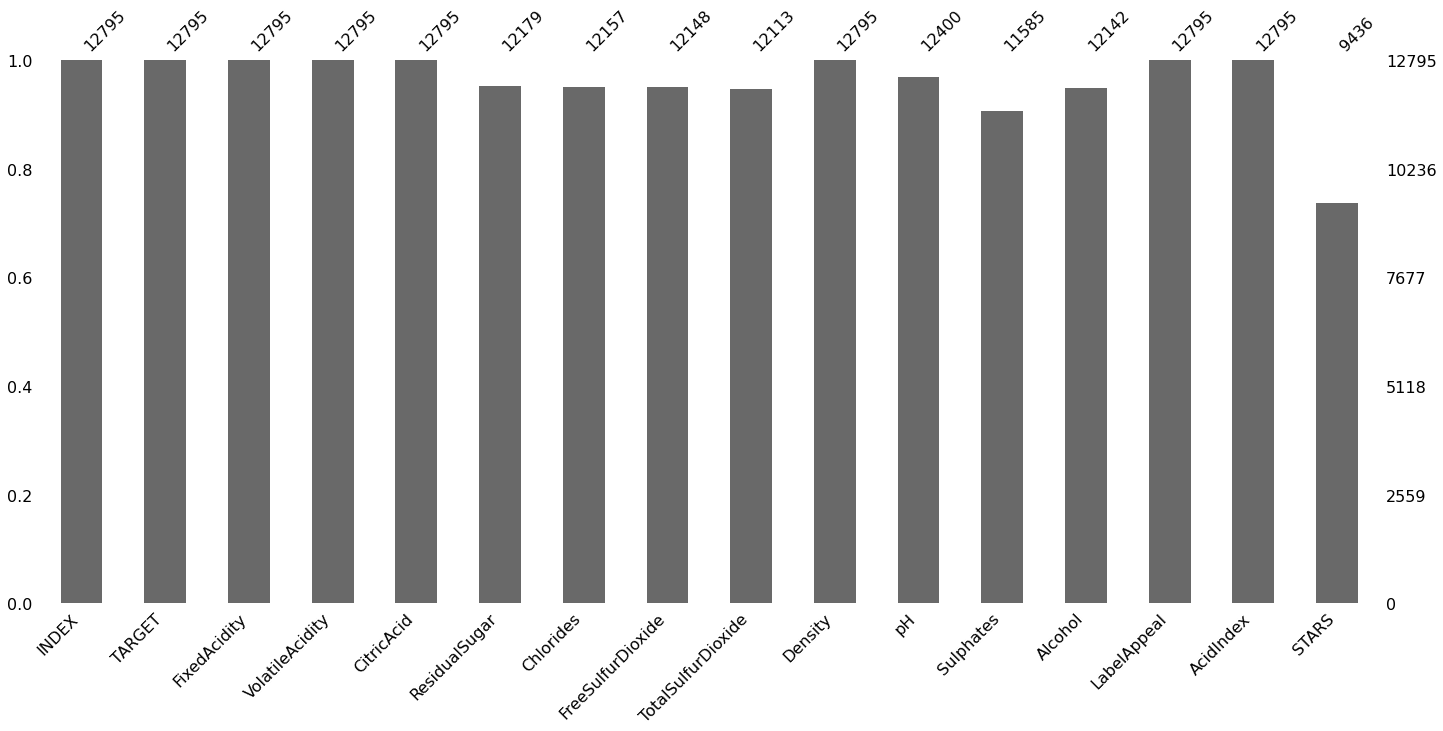

In [309]:
msno.bar(wine_data)

Let's take a look at where our missing data is located to see if there's any discernable pattern we can isolate.

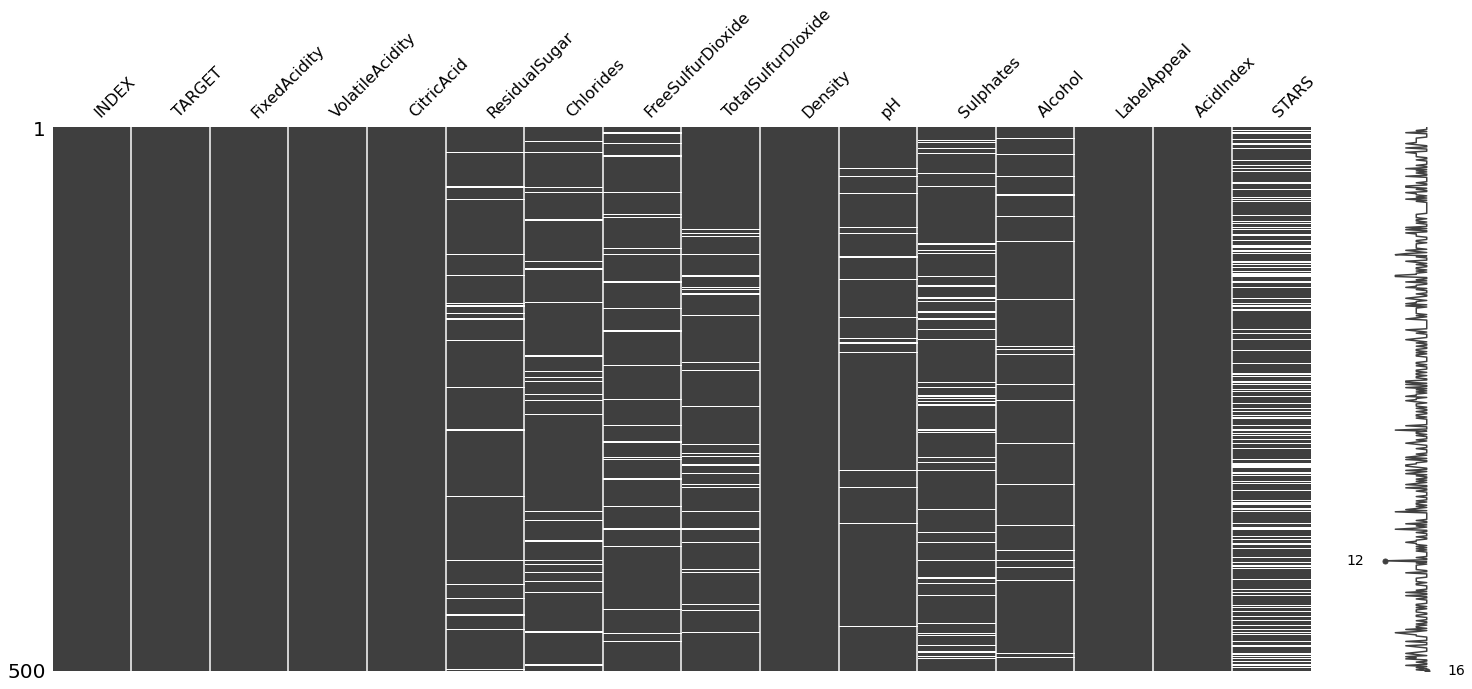

In [310]:
msno.matrix(wine_data.sample(500))

It looks like the missing data is randomly distributed, there's no observable patterns in the missing data (e.g. no significant consecutive chunks of missing data)

Let's look at the heat map to see if there's any correlation in the missing data

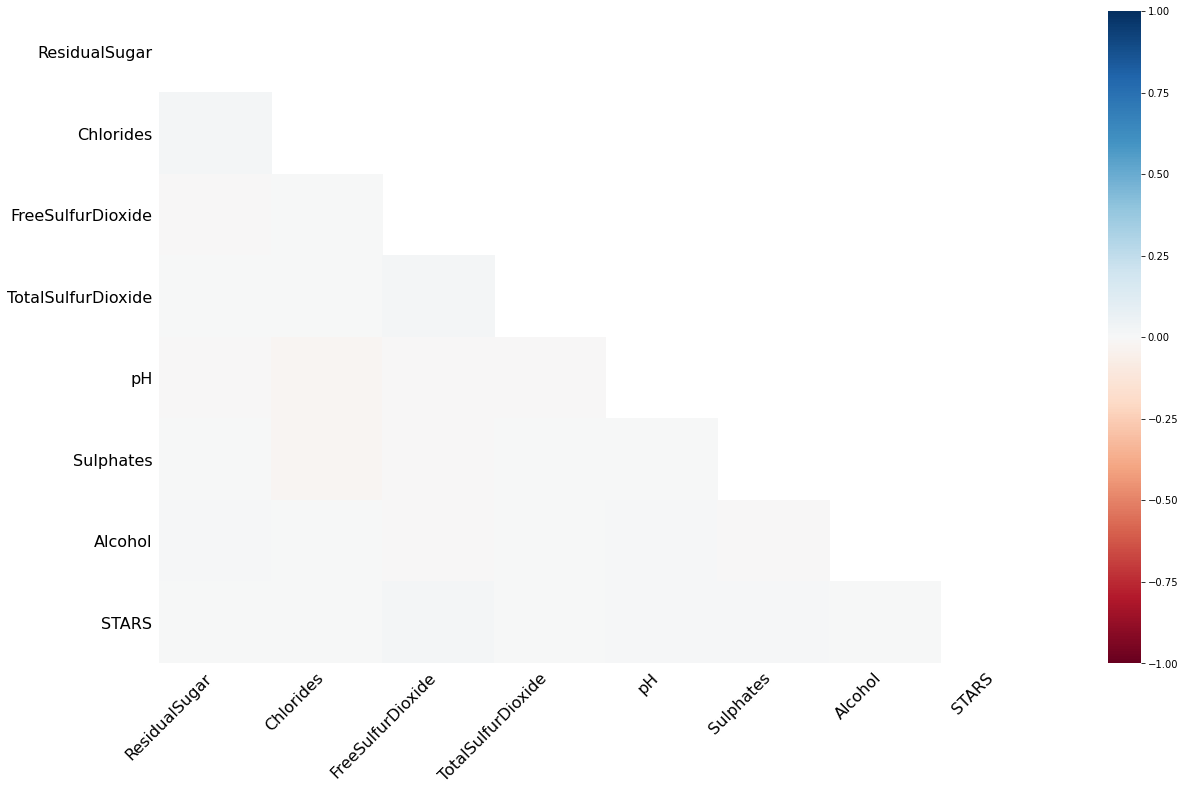

In [311]:
msno.heatmap(wine_data)

It looks like there's no correlation in any of the missing data so we're going to have to treat these missing values as completely random

#### Distribution

Now, we're going to take a look at the initial distribution of the dataset. This is likely going to change given all the negative and missing values.

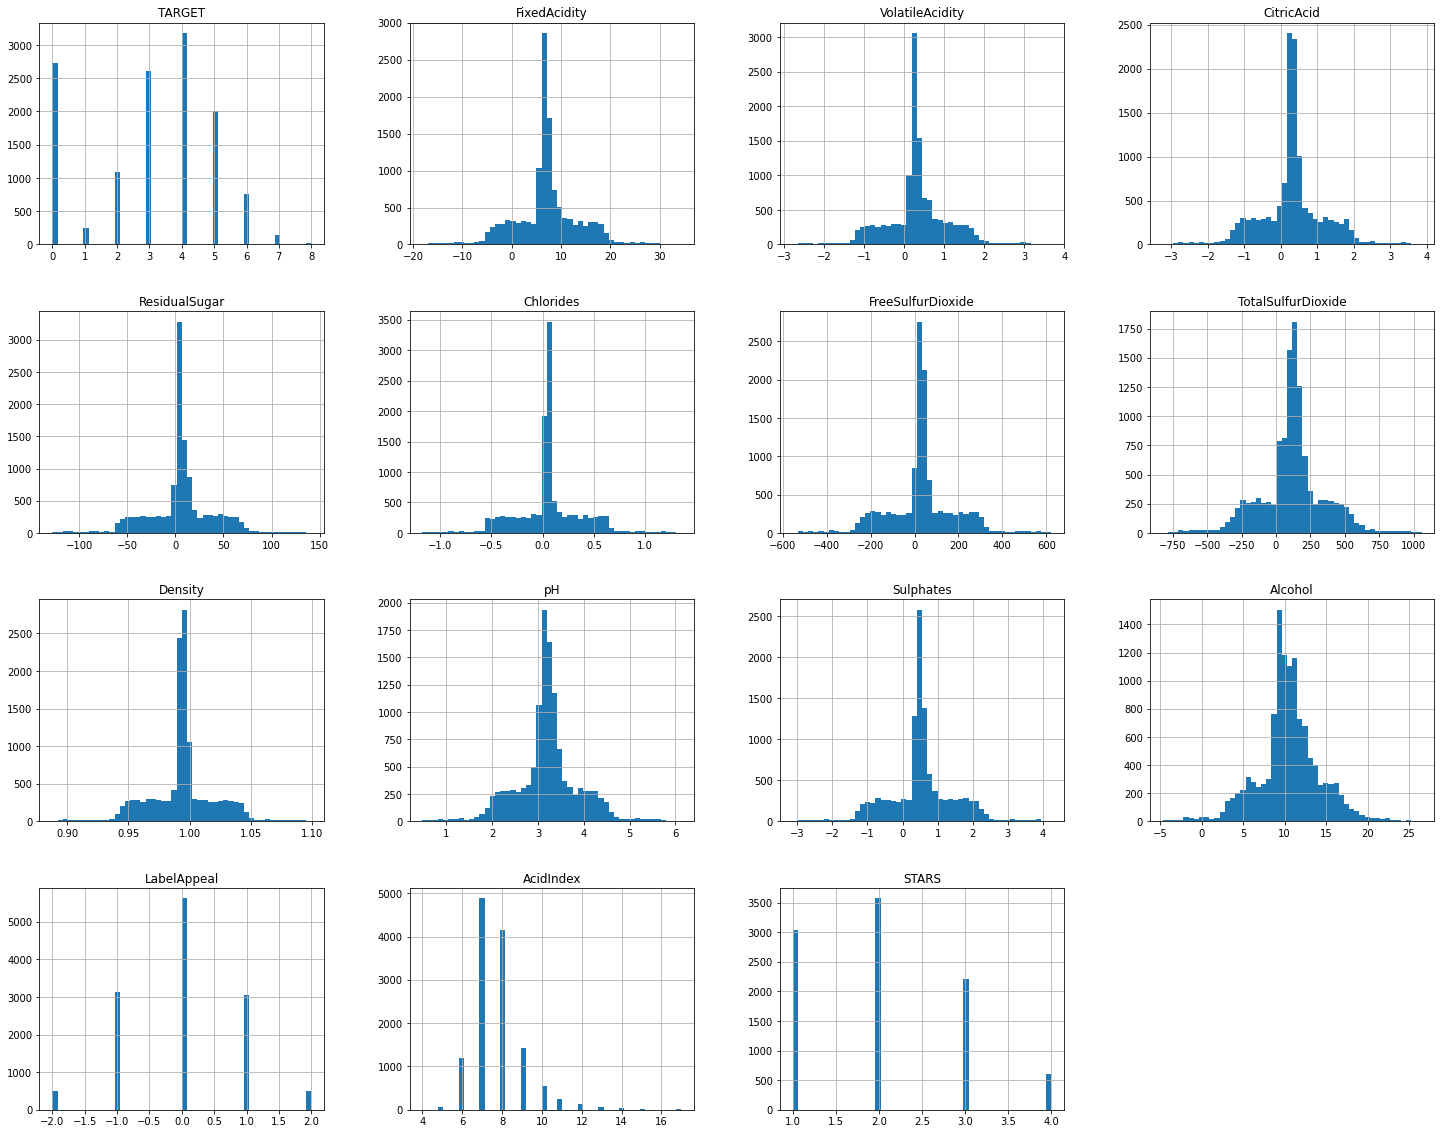

In [312]:
wine_data.iloc[:,1:].hist(bins=50, figsize=(25, 20))
plt.show()

It looks like most of the data is relatively normally distributed. The notable exceptions are:

- "TARGET", our response variable, has a lot of 0s. This is strange as it represents the number of cases sold. It seems highly unlikely that you'd have so many wines that haven't sold a single case. Maybe those are wines that haven't gone on sale yet, in which case they would be introducing a bias to our data.
- "AcidIndex" has a pretty significant right-skew.
- "STARS" also has a pretty significant right-skew


#### Outliers

Next, we're going to take a look at the boxplots of each variable to see if we can identify the outliers.

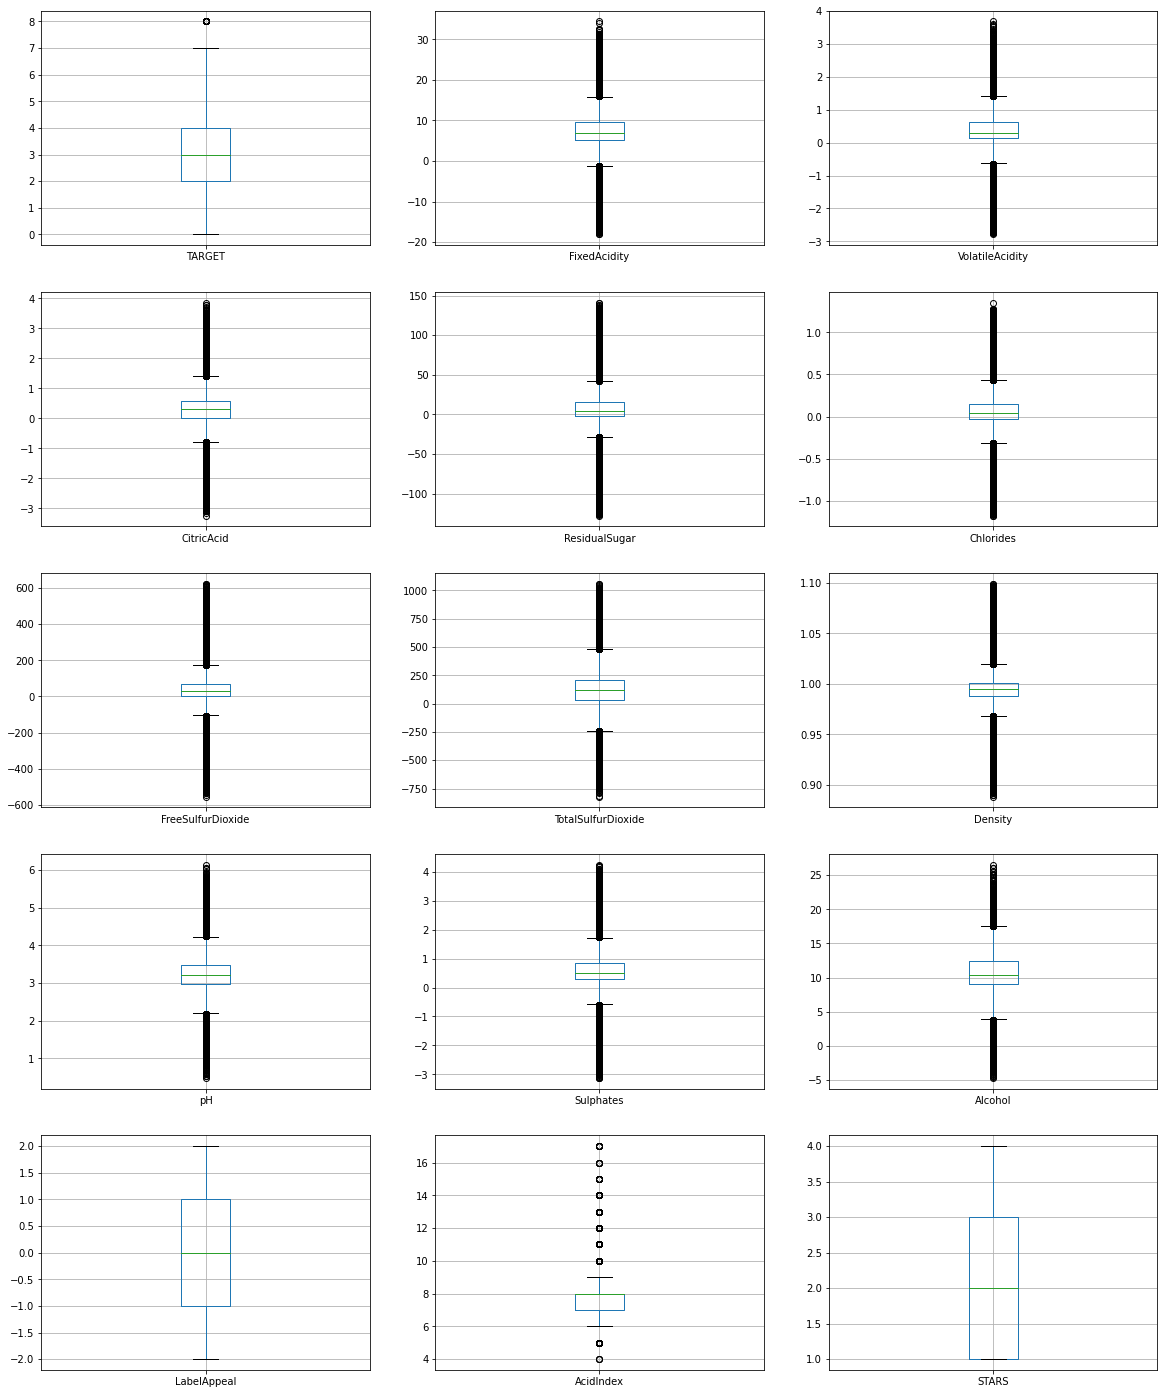

In [313]:
plt.figure(figsize=(20, 25))

j = 1
for col in wine_data.iloc[:,1:].columns:
  plt.subplot(5, 3, j)
  wine_data.boxplot(column=col)
  j = j+1

plt.show()

It looks like there are many variables that have numerous outliers. "LabelAppeal", "STARS", and "TARGET" appear to be the only variables without significant outliers.

#### Correlation

Let's see if we can find any correlation before we clean the data. This is just to get an idea of what the data looks like now as it's likely to change when we deal with the negative and missing values.

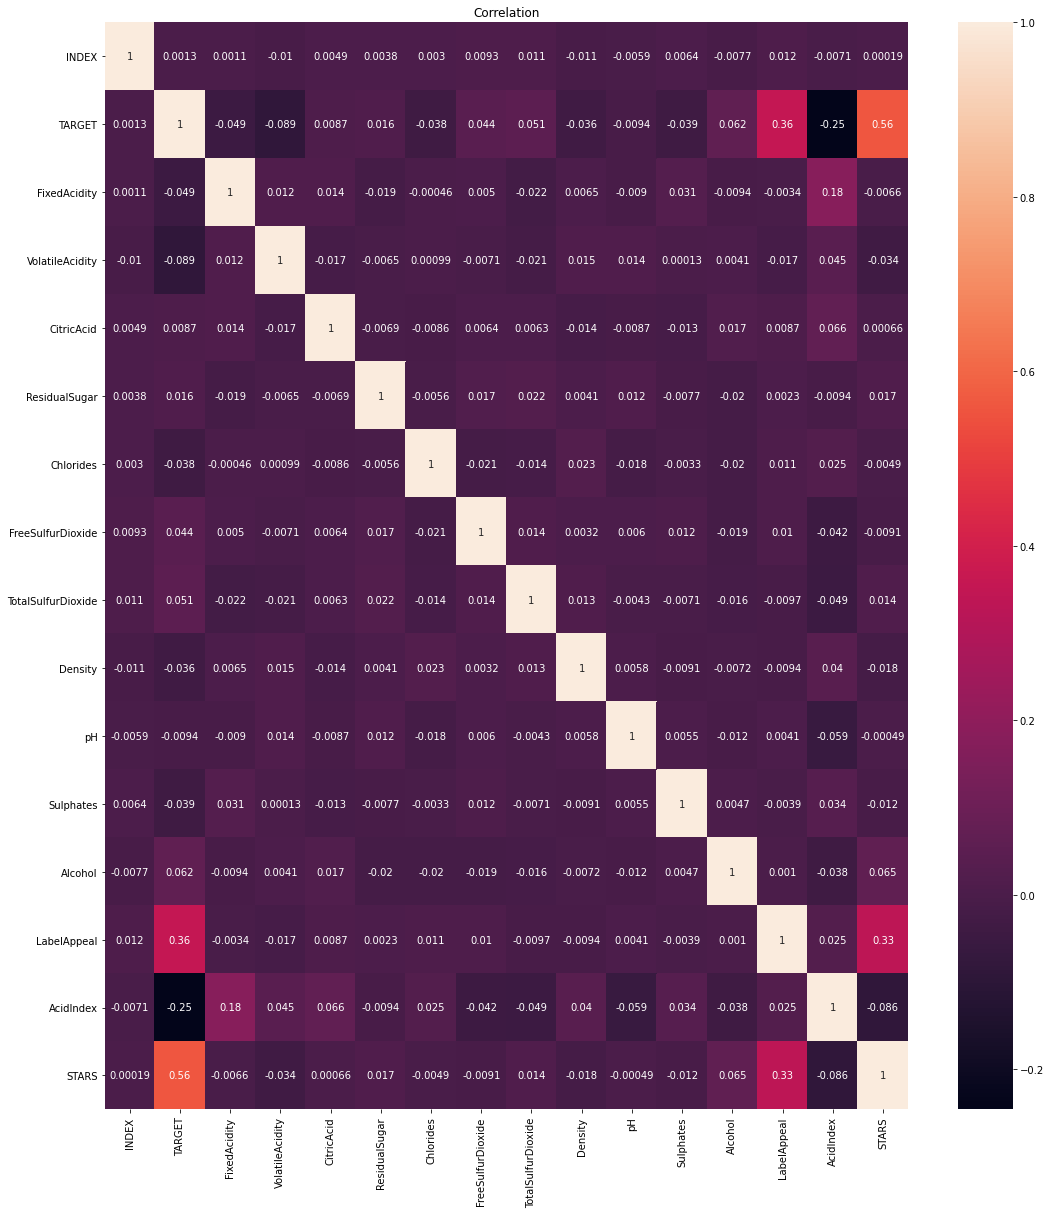

In [314]:
cor = wine_data.corr()
plt.figure(figsize=(18, 20))
plt.title("Correlation")
sns.heatmap(cor, annot=True)
plt.show()

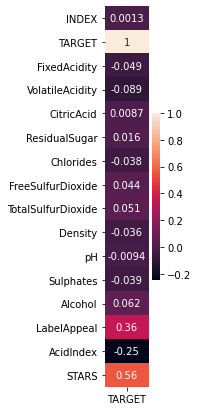

In [315]:
# set figure
plt.figure(figsize=(1, 7))

# Get correlation numbers just for response variable
target_cor = cor[['TARGET']]
sns.heatmap(target_cor, annot=True)
plt.show()

__Takeaways__

- There are very few strong correlations to our response variable.
- "STARS" has the strongest correlation to "TARGET" at 0.56.
- "LabelAppeal" has a relatively strong positive correlation with "TARGET" at 0.36
- "AcidIndex" has a negative correlation of -0.25, making in the 3rd most correlated variable to "TARGET"

## __3. Data Preperation__

### __Negatives__

Let's start by eliminating all the negatives. This will allow us to using imputing methods later to fill in the missing values.

We have a few options when it comes to handling negative values:

1. Add a constant to shift the data so that the minimum becomes 0.
2. Assume the negative symbol was a mistake and take the absolute value of all negative values.
3. Delete all rows that contain a negative value.
4. Delete all columns that contain a negative value.

We've already ruled out option 3 since it would erase too much useable data. Similarly, option 2 is not viable since there's still a significant amount of useable data in each column. Let's look at each affected cloumn one by one and decide what to do with them.

#### __LabelAppeal__

LabelAppeal is a subjective metric that indicates how marketable a wine is based soley on it's label. The range we have in our dataset for LabelAppeal is -2 - 2. This doesn't make a whole lot of sense as it could've just as easily be on a 0-4 scale. Since this is categorical/ordinal data, we're just going to create dummy variables to represent the scale.

-2 --> AwfulLabelAppeal
<br>
-1 --> BadLabelAppeal
<br>
0 --> NeutralLabelAppeal
<br>
1 --> GoodLabelAppeal
<br>
2 --> ExcellentLabelAppeal

In [316]:
dummies = pd.get_dummies(wine_data['LabelAppeal'], prefix="LabelAppeal")

dummies.columns = ['AwfulLabelAppeal',
                   'BadLabelAppeal',
                   'NeutralLabelAppeal',
                   'GoodLabelAppeal',
                   'ExcellentLabelAppeal']
dummies.head()

,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
0,0,0,1,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [317]:
# create new df with dumies by combining dummies with original df
wine_with_dummies = wine_data.iloc[:,1:].join(dummies)

# drop LabelAppeal
wine_with_dummies.drop(columns=['LabelAppeal'], inplace=True)

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
0,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,8,2.0,0,0,1,0,0
1,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,7,3.0,0,1,0,0,0
2,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,8,3.0,0,1,0,0,0
3,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,6,1.0,0,1,0,0,0
4,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,9,2.0,0,0,1,0,0


#### __Chlorides__

Measure the concentration of salt in the wine. According to [this](https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612015000100095#:~:text=Wine%20contains%20from%202%20to,2003%3B%20Maltman%2C%202013) Scielo study, 

> Wine contains from 2 to 4 g L–1 of salts of mineral acids, along with some organic acids, and they may have a key role on a potential salty taste of a wine, with chlorides being a major contributor to saltiness.

Some countries have mandated a maximum amount of chloride in wines. In Austrailia, for example, a wine can't have more than 606 mg/L of chloride ions. In Argentina, that number is lowerd to 364 mg/L. [Source](https://www.awri.com.au/s1530/)

It looks like 1 is the upper limit of g/L of chloride in wines, as more than this is illegal in most countries, as you can see in the below image.

![Image](https://www.scielo.br/img/revistas/cta/v35n1//0101-2061-cta-35-1-95-gf01.jpg)

The lower limit is obviously 0 as you can't have a negative chloride content.Our range of chloride is -1.17 - 1.35 so it's unlikely that the data was shifted. Thus, we're going to assume that the negatives were entered in error and take the absolute value of all the chloride data points.

In [318]:
# change all negatives to positive
wine_with_dummies['Chlorides'] = np.abs(wine_with_dummies['Chlorides'])

# make sure it worked
wine_with_dummies['Chlorides'].where(wine_with_dummies['Chlorides']<0).count()

0

#### __Residual Sugar__

This represents the quantity of sugar left in the wine after the fermentation process. According to [this](https://alfredsommelier.com/en/everything-there-is-to-know-about-residual-sugar-in-wine/#:~:text=The%20residual%20sugar%20is%20the,than%2045%20grams%20per%20liter.) source,

> a dry wine contains from 0 to 4 grams of sugar per liter, a semi-dry wine from 4 to 12 grams per liter, a semi-sweet wine from 8 to 45 grams per liter and a sweet wine contains more than 45 grams per liter.

And according to [Wine Folly](https://winefolly.com/deep-dive/sugar-in-wine-chart/),

> Wines range from 0 to 220 grams per liter sugar (g/L)

Our data ranges from -127.8 - 141.15. If we assume the data was shifted, that would bring our max to 268.93, slightly more than the max we found in our research. However, if we assume the negatives were entered in error, our max would be significantly lower than 220.

Let's work with the assumption that the data was shifted and see how many outliers we'd have that exceed our max of 220.

In [319]:
# Create new row with shifted ResidualSugar column
wine_with_dummies['ResidualSugarShifted'] = wine_with_dummies['ResidualSugar'] + np.abs(wine_with_dummies['ResidualSugar'].min())

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,ResidualSugarShifted
0,3,3.2,1.160,-0.98,54.2,0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,8,2.0,0,0,1,0,0,182.0
1,3,4.5,0.160,-0.81,26.1,0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,7,3.0,0,1,0,0,0,153.9
2,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,8,3.0,0,1,0,0,0,142.6
3,3,5.7,0.385,0.04,18.8,0.425,22.0,115.0,0.99640,2.24,1.83,6.2,6,1.0,0,1,0,0,0,146.6
4,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,9,2.0,0,0,1,0,0,137.2


In [320]:
wine_with_dummies['ResidualSugarShifted'].where(wine_with_dummies['ResidualSugarShifted']<0).count()

0

In [321]:
# Check how many outliers there are
residual_sugar_outliers = wine_with_dummies[wine_with_dummies['ResidualSugarShifted'] > 220]

residual_sugar_outliers.shape[0]

146

It looks like there would only be 146 outliers if we assumed the data was shifted. I think this makes the most sense with the information we have. Let's change the ResidualSugar column to reflect this shift.

In [322]:
# drop the rows with residual sugar outliers
wine_with_dummies.drop(residual_sugar_outliers.index.values, inplace=True)

wine_with_dummies.shape

(12649, 20)

In [323]:
# Change ResidualSugars column to the shifted data
wine_with_dummies['ResidualSugar'] = wine_with_dummies['ResidualSugarShifted']

# Drop shifted column
wine_with_dummies.drop(columns=['ResidualSugarShifted'], axis=1, inplace=True)

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
0,3,3.2,1.160,-0.98,182.0,0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,8,2.0,0,0,1,0,0
1,3,4.5,0.160,-0.81,153.9,0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,7,3.0,0,1,0,0,0
2,5,7.1,2.640,-0.88,142.6,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,8,3.0,0,1,0,0,0
3,3,5.7,0.385,0.04,146.6,0.425,22.0,115.0,0.99640,2.24,1.83,6.2,6,1.0,0,1,0,0,0
4,4,8.0,0.330,-1.26,137.2,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,9,2.0,0,0,1,0,0


In [324]:
wine_with_dummies['ResidualSugar'].where(wine_with_dummies['ResidualSugar']<0).count()

0

#### __Free & Total Sulfur Dioxide__

According to [this](https://www.wineshopathome.com/understanding-sulfur-levels-wine/) source,

>Sulfur dioxide (SO2 for short) is by far the most important additive used in wine. Many times it is the only additive. Its value derives from its ability to perform several crucial functions. It preserves wine’s freshness and fruit characters by virtue of antioxidant, antimicrobial and anti-enzymatic properties.

...

> SO2 that is present in wine but has not yet reacted is considered “free.” Free SO2 is what is still available to protect the wine.

According to this [paper](https://www.extension.iastate.edu/wine/sulfur-dioxide-measurement-and-overestimation-red-wine#:~:text=When%20bisulfite%20forms%20binds%20with,mg%2FL%20(ppm).) from Iowa State University,

>The total SO2 is achieved by adding the free and bound, and has a legal limit set by the TTB (Alcohol and Tobacco Tax and Trade Bureau) of 350 mg/L. 

For the purposes of this assesment, we're going to use that number as our max. This is problematic since we have a range of -555 - 623 for Free Sulfur Dioxide, and -823 - 1057 for Total Sulfur Dioxide. Let's first change all the negatives by taking their absolute value, then we'll see how many outliers we have.



In [325]:
# Set columns to absolute values
wine_with_dummies['TotalSulfurDioxide'] = np.abs(wine_with_dummies['TotalSulfurDioxide'])
wine_with_dummies['FreeSulfurDioxide'] = np.abs(wine_with_dummies['FreeSulfurDioxide'])

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
0,3,3.2,1.160,-0.98,182.0,0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,8,2.0,0,0,1,0,0
1,3,4.5,0.160,-0.81,153.9,0.425,15.0,327.0,1.02792,3.38,0.70,NaN,7,3.0,0,1,0,0,0
2,5,7.1,2.640,-0.88,142.6,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,8,3.0,0,1,0,0,0
3,3,5.7,0.385,0.04,146.6,0.425,22.0,115.0,0.99640,2.24,1.83,6.2,6,1.0,0,1,0,0,0
4,4,8.0,0.330,-1.26,137.2,NaN,167.0,108.0,0.99457,3.12,1.77,13.7,9,2.0,0,0,1,0,0


In [326]:
wine_with_dummies['TotalSulfurDioxide'].where(wine_with_dummies['TotalSulfurDioxide']<0).count()

0

In [327]:
wine_with_dummies['FreeSulfurDioxide'].where(wine_with_dummies['FreeSulfurDioxide']<0).count()

0

In [328]:
# Check for outliers
so2_outliers = wine_with_dummies[(wine_with_dummies['TotalSulfurDioxide']>350) | (wine_with_dummies['FreeSulfurDioxide']>350)]

so2_outliers.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
7,4,6.5,-1.220,0.34,129.20,0.040,523.0,551.0,1.03236,3.20,NaN,11.6,7,3.0,0,0,0,1,0
10,0,-17.2,0.520,0.15,94.00,0.022,551.0,65.0,0.99340,4.31,0.56,13.1,5,1.0,0,0,0,1,0
12,3,6.0,0.330,-1.06,130.80,0.518,5.0,378.0,0.96643,3.55,-0.86,3.9,7,2.0,0,0,0,1,0
19,4,6.8,0.475,-0.20,77.05,0.047,88.0,508.0,0.99403,3.23,0.35,18.3,8,2.0,0,1,0,0,0
46,4,11.0,0.230,1.42,165.60,0.035,NaN,434.0,0.99760,3.35,0.52,9.4,7,4.0,0,0,1,0,0


In [329]:
so2_outliers.shape[0]

2310

It looks like we have 2,310 observations that exceed the legal limit of total s02. This is ~18.2% of our data which is significant, but I don't think we can move forward with those observations so we need to drop those rows.

In [330]:
wine_with_dummies.drop(so2_outliers.index.values, inplace=True)

wine_with_dummies.shape

(10339, 19)

It also looks like we have rows in which the Free SO2 is greater than the Total SO2. This is not possible as Total SO2 is merely the combination of Free SO2 and Bound SO2. Since Bound SO2 can't be negative, it's not possible for Free SO2 to exceed Total SO2.

In [331]:
# get all rows in which free so2 exceeds total so2
impossible_so2 = wine_with_dummies[wine_with_dummies['FreeSulfurDioxide'] > wine_with_dummies['TotalSulfurDioxide']]

impossible_so2.shape[0]

2730

There are 2,730 rows with impossible SO2 occurances. These must be dropped too.

In [332]:
wine_with_dummies.drop(impossible_so2.index.values, inplace=True)

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
0,3,3.2,1.160,-0.98,182.00,0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,8,2.0,0,0,1,0,0
1,3,4.5,0.160,-0.81,153.90,0.425,15.0,327.0,1.02792,3.38,0.70,NaN,7,3.0,0,1,0,0,0
3,3,5.7,0.385,0.04,146.60,0.425,22.0,115.0,0.99640,2.24,1.83,6.2,6,1.0,0,1,0,0,0
8,3,14.8,0.270,1.05,139.05,0.007,213.0,NaN,0.99620,4.93,0.26,15.0,6,NaN,0,0,1,0,0
9,6,5.5,-0.220,0.39,129.60,0.277,62.0,180.0,0.94724,3.09,0.75,12.6,8,4.0,0,0,1,0,0


In [333]:
wine_with_dummies.shape

(7609, 19)

In [334]:
wine_with_dummies.describe()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,AcidIndex,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
count,7609.000000,7609.000000,7609.000000,7609.00000,7243.000000,7218.000000,7070.000000,6950.000000,7609.000000,7379.000000,6862.000000,7209.000000,7609.000000,5639.000000,7609.000000,7609.000000,7609.000000,7609.000000,7609.000000
mean,3.047050,7.011736,0.325594,0.32131,131.657725,0.224120,57.093423,162.250072,0.994282,3.198675,0.523755,10.524712,7.753713,2.046639,0.040084,0.244842,0.441319,0.236036,0.037718
std,1.927551,6.332100,0.789291,0.86508,31.392029,0.235189,57.008807,79.607292,0.026225,0.672105,0.931456,3.717785,1.310019,0.904517,0.196169,0.430022,0.496577,0.424673,0.190527
min,0.000000,-18.100000,-2.730000,-3.16000,0.700000,0.000000,0.000000,1.000000,0.888090,0.530000,-3.130000,-4.700000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,0.130000,0.04000,124.300000,0.046000,22.000000,107.000000,0.988510,2.940000,0.270000,9.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,6.900000,0.280000,0.31000,131.300000,0.103000,37.000000,151.000000,0.994500,3.190000,0.500000,10.400000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,9.400000,0.640000,0.61000,142.800000,0.369000,66.000000,212.000000,1.000810,3.450000,0.860000,12.400000,8.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,8.000000,32.500000,3.590000,3.86000,218.900000,1.351000,348.000000,350.000000,1.096790,6.130000,4.240000,26.100000,17.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### __Citric Acid__

According to [this](https://www.accuvin.com/wp-content/uploads/2015/04/Monitoring-Acids-and-pH-in-Winemaking.pdf) paper,

>Citric acid is a minor acid of grapes, appearing at levels up to 10% of the total acid content, or 0.1–0.7 g/L.  Citric acid is produced by yeasts during primary fermentation (at ~0.1 – 0.4 g/L), dependent upon yeast strain used.

This means that we can expect ~0.2-1.1 g/L of naturally occuring citric acid in wines.

However, some winemakers add citric acid to the wine to increase the tartness or acidity of the wine. According to the same paper as above,

>Citric acid has occasionally been used as an acidulant.  It is generally not recommended.  It can be broken down by lactic acid bacteria, producing excess diacetyl and troublesome amounts of acetic acid.  It is useful at levels of 100 – 120 mg/L to react with excess iron in wine and reduce the likelihood of iron casse developing.

It looks like the amount of citric acid added to wines varies greatly, especially among white wines, so we're going to assume that are dataset doesn't include any false data on the high end. We're also going to assume that the negative values were input in error since the citric acid level in a wine is a zero-bound variable. Therefore, we're going to set those all to their absolute value.



In [335]:
wine_with_dummies['CitricAcid'] = np.abs(wine_with_dummies['CitricAcid'])

wine_with_dummies['CitricAcid'].where(wine_with_dummies['CitricAcid']<0).count()

0

Now, we're going to check for outliers in this column, using 2.5 standard deviations as our meassure. 

In [336]:
citric_acid_outliers = wine_with_dummies[np.abs(wine_with_dummies['CitricAcid'] - wine_with_dummies['CitricAcid'].mean()) > (2 * wine_with_dummies['CitricAcid'].std())]

print(citric_acid_outliers['CitricAcid'].min())
print(citric_acid_outliers.shape[0])

1.92
365


The cutoff point for our outliers is 1.92 and we have 365 of them. Let's remove those from our dataset

In [337]:
wine_with_dummies.drop(citric_acid_outliers.index.values, inplace=True)

wine_with_dummies.shape

(7244, 19)

#### __Volatile Acidity__

According to the [Penn State Extension](https://extension.psu.edu/volatile-acidity-in-wine),

>Volatile acidity (VA) is a measure of the wine's volatile (or gaseous) acids. The primary volatile acid in wine is acetic acid, which is also the primary acid associated with the smell and taste of vinegar.

The same paper says that volatile acidity is regulated by the Federal Tax and Trade Bureau. The limits are:

>In general, per the CFR: "The maximum volatile acidity, calculated as acetic acid and exclusive of sulfur dioxide, is 0.14 g/100 mL for red wine and 0.12 g/100 mL for white wines." This is equivalent to 1.4 and 1.2 g/L acetic acid for red and white wines, respectively.

Thus, we can assume any numbers above 1.4 g/L is incorrect and remove that observation from our dataset. First, let's change all the negative values to their absolute values as volatile acidity is a zero-bound variable

In [338]:
# change negatives to positive
wine_with_dummies['VolatileAcidity'] = np.abs(wine_with_dummies['VolatileAcidity'])

wine_with_dummies['VolatileAcidity'].where(wine_with_dummies['VolatileAcidity']<0).count()

0

In [339]:
volatile_acidity_outliers = wine_with_dummies[wine_with_dummies['VolatileAcidity']>1.4]

volatile_acidity_outliers.shape

(786, 19)

In [340]:
wine_with_dummies.drop(volatile_acidity_outliers.index.values, inplace=True)

wine_with_dummies.shape

(6458, 19)

#### __Sulphates__

According to [this](https://www.thespruceeats.com/what-are-wine-sulfites-3511277) source,

>Wine sulfites are naturally occurring at low levels in all wines, and are one of the thousands of chemical by-products created during the fermentation process.

According to [this]() source,

>Wine ranges from about 5 mg/L (5 parts per million) to about 200 mg/L. The maximum legal limit in the United States is 350 mg/l.

However, in Europe, the law allows for higher amounts of sulfites, as stated in [this](https://www.scientistlive.com/content/total-sulphite-wine) source:

>In Europe legal limits for Red wines: 160mg/L, White/Rose wines: 210mg/L and Sweet wines: 400mg/L, US legal limits: 350mg/L and Australia 250mg/L.

Therefore, let's use 400 mg/L, or .4 g/L as our baseline. First, let's change all the negative values to their absolute values to remove negatives.



In [341]:
wine_with_dummies['Sulphates'] = np.abs(wine_with_dummies['Sulphates'])

wine_with_dummies['Sulphates'].where(wine_with_dummies['Sulphates']<0).count()

0

In [342]:
sulphate_outliers = wine_with_dummies[wine_with_dummies['Sulphates']>.4]

sulphate_outliers.shape

(4569, 19)

There are 4,569 observations of wine that exceeds the legal limit of sulphates. This is incredibly high (~71% of our total data) and calls into question the validity of the dataset. However, for the purposes of this excercise, we're going to move forward with our analysis assuming the rest of the data is accurate.

Let's remove all sulphate outliers from our dataset

In [343]:
wine_with_dummies.drop(sulphate_outliers.index.values, inplace=True)

wine_with_dummies.shape[0]

1889

#### __Fixed Acidity__

According to [Waterhouse Lab](https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity),

>Acids are major wine constituents and contribute greatly to its taste.  In fact, acids impart the sourness or tartness that is a fundamental feature in wine taste.

...

>The predominant fixed acids found in wines are tartaric, malic, citric, and succinic.  Their respective levels found in wine can vary greatly but in general one would expect to see 1,000 to 4,000 mg/L tartaric acid, 0 to 8,000 mg/L malic acid, 0 to 500 mg/L citric acid, and 500 to 2,000 mg/L succinic acid.

This adds up to a total fixed acity level of 1,500 - 14,500 mg/L, or 1.5 - 14.5 g/L.

Let's first convert all the negative values to positive values, then remove the outliers.

In [344]:
wine_with_dummies['FixedAcidity'] = np.abs(wine_with_dummies['FixedAcidity'])

wine_with_dummies['FixedAcidity'].where(wine_with_dummies['FixedAcidity']<0).count()

0

In [345]:
# find fixed acidity outliers
fixed_acidity_outliers = wine_with_dummies[wine_with_dummies['FixedAcidity']>14.5]

fixed_acidity_outliers.shape[0]

226

It looks like we have 226 fixed acidity outliers. Let's remove them from our dataset

In [346]:
wine_with_dummies.drop(fixed_acidity_outliers.index.values, inplace=True)

wine_with_dummies.shape[0]

1663

We're now down to 1,663 observations in our dataset, which brings us to our final variable containing negative values, Alcohol content

#### __Alcohol__

According to [Real Simple](https://www.realsimple.com/holidays-entertaining/entertaining/food-drink/alcohol-content-wine#:~:text=The%20average%20glass%20of%20wine,of%20your%20mouth%20or%20throat.),

>The degree of alcohol in any given glass of wine is equivalent to its percentage by volume, and is often referred to as ‘ABV’ (or alcohol by volume).

...

>The average glass of wine contains around 11% to 13% alcohol, but bottles range from as little as 5.5% alcohol by volume to as much as around 20% ABV.

However, it doesn't seem like there's a consensus on the upper limit of alcohol content in wines. [Wine Folly](https://winefolly.com/tips/the-lightest-to-the-strongest-wine/) claims:

>Alcohol content in wine ranges wildly from as low as 5.5% to 23% ABV.

There certainly isn't a legal limit to alcohol content. Thus, our max of 26.5% seems reasonable. We'll keep that as is.

Let's just convert the negative values to positive.

In [347]:
wine_with_dummies['Alcohol'] = np.abs(wine_with_dummies['Alcohol'])

wine_with_dummies['Alcohol'].where(wine_with_dummies['Alcohol']<0).count()

0

#### Check Negatives

We should now be done with our categories that contained negative values. Let's double-check just to confirm that there are no negative values left in our dataset.

In [348]:
negatives = wine_with_dummies.where(wine_with_dummies<0).count()
negatives

TARGET                  0
FixedAcidity            0
VolatileAcidity         0
CitricAcid              0
ResidualSugar           0
Chlorides               0
FreeSulfurDioxide       0
TotalSulfurDioxide      0
Density                 0
pH                      0
Sulphates               0
Alcohol                 0
AcidIndex               0
STARS                   0
AwfulLabelAppeal        0
BadLabelAppeal          0
NeutralLabelAppeal      0
GoodLabelAppeal         0
ExcellentLabelAppeal    0
dtype: int64

### __Outliers__

After eliminating negative values and their outliers, we still have 6 columns we haven't checked for outliers:

- STARS
- AcidIndex
- pH
- Density
- TARGET
- INDEX

We can eliminate STARS because it's categorical data. We can also eliminate INDEX because it's not relevant to our analysis since it's merely a unique ID given to each observation. We're also going to eliminate TARGET as this is our response variable so there's no upper or lower limit for it. That leaves us with 3 categories to check for outliers.

#### __Acid Index__

[This](http://www.bcawa.ca/winemaking/acidph.htm) source defines Acid Index as:

>Simply a matter of subtracting the pH from the [Total Acidity].

However, the source of our dataset describes it as,

>total acidity of wine via a weighted average.

This sounds more like Total Acidity, or the sum of volatile and fixed acidities. This also lines up more closely with our given data, as the range of IA (Index of Acidity) typically ranges from 2-4.8. Meanwhile, based on our definitions of fixed and volatile acidity above, Total Acidity would range from 1.5 - 15.9 g/L, much more in line with the data we have.

I'm going to change the name of this column to "TotalAcidity" to avoid further confusion.

In [349]:
wine_with_dummies.rename(columns={'AcidIndex': 'TotalAcidity'}, inplace=True)

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
11,4,9.0,0.22,0.49,138.2,0.150,NaN,195.0,1.05918,3.01,0.40,10.2,10,2.0,0,0,1,0,0
15,0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,NaN,6.8,8,NaN,0,0,1,0,0
25,0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.40,15.2,7,NaN,0,1,0,0,0
28,4,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,NaN,16.6,9,2.0,0,0,1,0,0
30,4,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.21,9.8,6,3.0,0,0,1,0,0


In [350]:
wine_with_dummies.describe()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,STARS,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal
count,1663.000000,1663.000000,1663.000000,1663.000000,1574.000000,1596.000000,1548.000000,1509.000000,1663.000000,1619.000000,1127.000000,1589.000000,1663.000000,1275.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000
mean,3.191822,6.546001,0.475878,0.611744,131.738469,0.221854,57.699289,163.610669,0.994176,3.155065,0.270949,10.613463,7.663860,2.061961,0.040289,0.254961,0.432952,0.236921,0.034877
std,1.869672,3.145677,0.341613,0.470767,32.170919,0.238874,56.166969,79.579353,0.026355,0.675868,0.120876,3.516823,1.275781,0.907022,0.196694,0.435970,0.495633,0.425321,0.183523
min,0.000000,0.000000,0.000000,0.000000,1.600000,0.000000,0.000000,1.000000,0.889490,0.590000,0.000000,0.100000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,0.230000,0.280000,125.525000,0.043000,23.000000,107.000000,0.988950,2.900000,0.180000,9.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,6.700000,0.335000,0.430000,131.850000,0.093000,38.000000,152.000000,0.994000,3.160000,0.320000,10.500000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,8.000000,0.660000,0.890000,142.700000,0.374500,68.625000,212.500000,0.999800,3.410000,0.370000,12.200000,8.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,8.000000,14.500000,1.400000,1.910000,218.800000,1.249000,334.000000,350.000000,1.093030,5.730000,0.400000,25.100000,17.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Given the fact that there's no concrete upper limit for TotalAcidity and our max of 17 comes very close to our estimated upper limit of 15.9, we're going to leave this column alone.

#### __pH__

According to [winemag.com](https://www.winemag.com/2019/06/19/what-is-acidity-in-wine/),

>The pH scale is measured from 0–14, with the ends of the spectrum being the strongest. Usually, if a wine has a high acid level, it will have a low pH. High acid/low pH wines are stable because their environment discourages the growth of bacteria and other microbes.

...

>The other important thing to remember is that the numbers on the scale are logarithmic, not linear, so instead of pH 5 being twice as acidic as pH 6, it’s actually 10 times as acidic.

In terms of the typical pH range for wines, winemag says:

>Acidic white vinegar tends to have a pH level of 2.5, while milk registers at around 6.5, and water clocks in at a neutral 7. Typically, the pH level of a wine ranges from 3 to 4.

Given the logorithmic nature of the pH scale, any slight increase or decrease in pH will have a tremendous impact on the wine. Thus, it's important we stay within that recommended 3 - 4pH range. We'll give some room for error and adjust our lower limit to 2.5 and our upper limit to 4.5


In [351]:
ph_outliers = wine_with_dummies[(wine_with_dummies['pH']>4.5) | (wine_with_dummies['pH']<2.5)]

ph_outliers.shape[0]

270

As you can see, there are 270 outliers that are outside of the 2.5 - 4.5pH range. Let's get rid of those observations

In [352]:
wine_with_dummies.drop(ph_outliers.index.values, inplace=True)

wine_with_dummies.shape[0]

1393

#### __Density__

Density, or specific gravity is defined [here](http://www.brewstore.co.uk/wp/wp-content/uploads/2014/04/taking-a-hydrometer-reading-and-calculating-the-alcohol-content-1.pdf) as:

>Density of a liquid with respect to water. Water has a specific gravity of 1.000

According to [this](https://blog.homebrewing.org/starting-final-specific-gravity-for-wine/) source,

> You should expect a final specific gravity for wine somewhere between .992 and .996 on your hydrometer.

and 

> Normally you would want a starting specific gravity between 1.070 and 1.100 for wine.

Based on these sources, it looks like our range of 0.889 - 1.093 is pretty accurate so we're going to leave it alone.

### __Nulls__

With our negative values and outliers sorted out, we can now move on to our null values. In our EDA, we saw 8 columns that contained null values:

- STARS - 26.3%
- Sulphates - 9.5%
- TotalSulfurDioxide - 5.3%
- Alcohol - 5.1%
- FreeSulfurDioxide - 5.1%
- Chlorides - 5%
- ResidualSugar - 4.8%
- pH - 3.1%

Let's run the code again to see how many nulls remain after cutting our dataset down in the negatives section

In [353]:
wine_with_dummies.isnull().sum()

TARGET                    0
FixedAcidity              0
VolatileAcidity           0
CitricAcid                0
ResidualSugar            78
Chlorides                59
FreeSulfurDioxide        95
TotalSulfurDioxide      129
Density                   0
pH                       44
Sulphates               454
Alcohol                  67
TotalAcidity              0
STARS                   328
AwfulLabelAppeal          0
BadLabelAppeal            0
NeutralLabelAppeal        0
GoodLabelAppeal           0
ExcellentLabelAppeal      0
dtype: int64

In [354]:
# percentage of null data
missing = wine_with_dummies.isnull().mean() * 100
missing.sort_values(inplace=True, ascending=False)

missing

Sulphates               32.591529
STARS                   23.546303
TotalSulfurDioxide       9.260589
FreeSulfurDioxide        6.819813
ResidualSugar            5.599426
Alcohol                  4.809763
Chlorides                4.235463
pH                       3.158650
FixedAcidity             0.000000
VolatileAcidity          0.000000
CitricAcid               0.000000
ExcellentLabelAppeal     0.000000
Density                  0.000000
GoodLabelAppeal          0.000000
TotalAcidity             0.000000
AwfulLabelAppeal         0.000000
BadLabelAppeal           0.000000
NeutralLabelAppeal       0.000000
TARGET                   0.000000
dtype: float64

It looks like Sulphates has overtaken STARS for the most missing data with 454 observations, or 32.6% of the dataset, containing a null value. Additionally, it looks like the remaining 7 categories still have significant amounts of missing data.

We have 4 approaches to dealing with missing data:

1. Fill all null values with mean, median, or mode of the column.
2. Use K-Nearest Neighbor to impute a value based on the observation's "nearest neighbors", or other observations which are most similar to it based on it's other features.
3. Use backfill and frontfill to impute a vlaue based on the observation which is cronologically before (frontfill) or behind (backfill) in the dataset.
4. Use an iterative imputer to impute a value based on a regression model of all the other observations. This approach sequentially updates each observation, allowing prior observations to be used in the next imputation.

#### __STARS__

STARS represent a subjective rating given to each wine by an expert.

This is a categorical variable, so we're not going to look for outliers. However, we can convert the variable to a format that's useable in a regression model. Let's convert our "STARS" variable to numeric by creating dummy variables for each category.

We still have 388 null "STAR" values which makes up ~23% of our dataset. We're going to treat this data as wines which haven't been reviewed yet.

First, we'll covnert them to 0s and then label them as unreviewed when we create the dummies for the category.

In [355]:
# convert null values to 0
wine_with_dummies['STARS'].fillna(0, inplace=True)

wine_with_dummies['STARS'].isnull().sum()

0

In [356]:
star_dummies = pd.get_dummies(wine_with_dummies['STARS'], prefix="Stars")

star_dummies.columns = ['Unreviewed',
                        'PoorRating',
                        'NeutralRating',
                        'GoodRating',
                        'ExcellentRating']

star_dummies.head()

,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
11,0,0,1,0,0
15,1,0,0,0,0
25,1,0,0,0,0
28,0,0,1,0,0
30,0,0,0,1,0


In [357]:
# add star dummies to our dataset
wine_with_dummies = wine_with_dummies.join(star_dummies)

# drop STARS from our dataset
wine_with_dummies.drop(columns=['STARS'], inplace=True)

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
11,4,9.0,0.22,0.49,138.2,0.150,NaN,195.0,1.05918,3.01,0.40,10.2,10,0,0,1,0,0,0,0,1,0,0
15,0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,NaN,6.8,8,0,0,1,0,0,1,0,0,0,0
25,0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.40,15.2,7,0,1,0,0,0,1,0,0,0,0
28,4,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,NaN,16.6,9,0,0,1,0,0,0,0,1,0,0
30,4,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.21,9.8,6,0,0,1,0,0,0,0,0,1,0


#### __KNN Imputer__

Let's try the K-Nearest Neighbor imputer here and compare the distribution before and after inputation

First, we need to use a scaler to normalize our data to avoid bias in our imputation.

In [358]:
scaler = MinMaxScaler()
wine_with_dummies_scaled = pd.DataFrame(scaler.fit_transform(wine_with_dummies), columns=wine_with_dummies.columns)
wine_with_dummies_scaled.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
0,0.5,0.620690,0.157143,0.256545,0.628913,0.119871,NaN,0.555874,0.833694,0.255,1.000,0.404,0.416667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.393103,0.357143,0.057592,0.609116,0.056315,0.700599,0.945559,0.532131,0.425,NaN,0.268,0.250000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.186207,0.728571,0.277487,0.378453,0.139179,0.179641,0.203438,0.519308,0.340,1.000,0.604,0.166667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.5,0.551724,0.007143,0.575916,0.787293,0.280772,0.050898,0.366762,0.718041,0.350,NaN,0.660,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.5,0.393103,0.178571,0.141361,0.630755,0.039421,0.173653,0.693410,0.328879,0.300,0.525,0.388,0.083333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Next, we create our imputer and run it on our scaled dataset

In [359]:
# initialize imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit imputer on scaled dataset
wine_with_dummies_imputed = pd.DataFrame(imputer.fit_transform(wine_with_dummies_scaled), columns=wine_with_dummies_scaled.columns)

# display null values
wine_with_dummies_imputed.isnull().sum()

TARGET                  0
FixedAcidity            0
VolatileAcidity         0
CitricAcid              0
ResidualSugar           0
Chlorides               0
FreeSulfurDioxide       0
TotalSulfurDioxide      0
Density                 0
pH                      0
Sulphates               0
Alcohol                 0
TotalAcidity            0
AwfulLabelAppeal        0
BadLabelAppeal          0
NeutralLabelAppeal      0
GoodLabelAppeal         0
ExcellentLabelAppeal    0
Unreviewed              0
PoorRating              0
NeutralRating           0
GoodRating              0
ExcellentRating         0
dtype: int64

As you can see, our data is now free of null values. However, it is unuseable as it is still scaled to be uniform. To solve this, we use `scaler.inverse_transform` to reverse the transformation and reset the data.

In [360]:
wine_with_dummies_imputed = pd.DataFrame(scaler.inverse_transform(wine_with_dummies_imputed))

wine_with_dummies_imputed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,4.0,9.0,0.22,0.49,138.2,0.150,33.2,195.0,1.05918,3.01,0.400,10.2,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,0.232,6.8,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.400,15.2,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,0.360,16.6,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.210,9.8,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


As you can see, the transformation of the data and casting as a pandas DataFrame caused us to lose our column names. To fix this, we set our column names to the appropriate names

In [363]:
wine_with_dummies_imputed.columns = ['TARGET', 
                                     'FixedAcidity',
                                     'VolatileAcidity',
                                     'CitricAcid',
                                     'ResidualSugar',
                                     'Chlorides',
                                     'FreeSulfurDioxide',
                                     'TotalSulfurDioxide',
                                     'Density',
                                     'pH',
                                     'Sulphates',
                                     'Alcohol',
                                     'TotalAcidity',
                                     'AwfulLabelAppeal',
                                     'BadLabelAppeal',
                                     'NeutralLabelAppeal',
                                     'GoodLabelAppeal',
                                     'ExcellentLabelAppeal',
                                     'Unreviewed',
                                     'PoorRating',
                                     'NeutralRating',
                                     'GoodRating',
                                     'ExcellentRating'
                                     ]

wine_with_dummies_imputed.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
0,4.0,9.0,0.22,0.49,138.2,0.150,33.2,195.0,1.05918,3.01,0.400,10.2,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,0.232,6.8,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.400,15.2,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,0.360,16.6,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.210,9.8,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### __Compare Distributions__

Now, let's take a look at the distribution of our data before we used the KNN Imputer and compare to our new data after imputation.

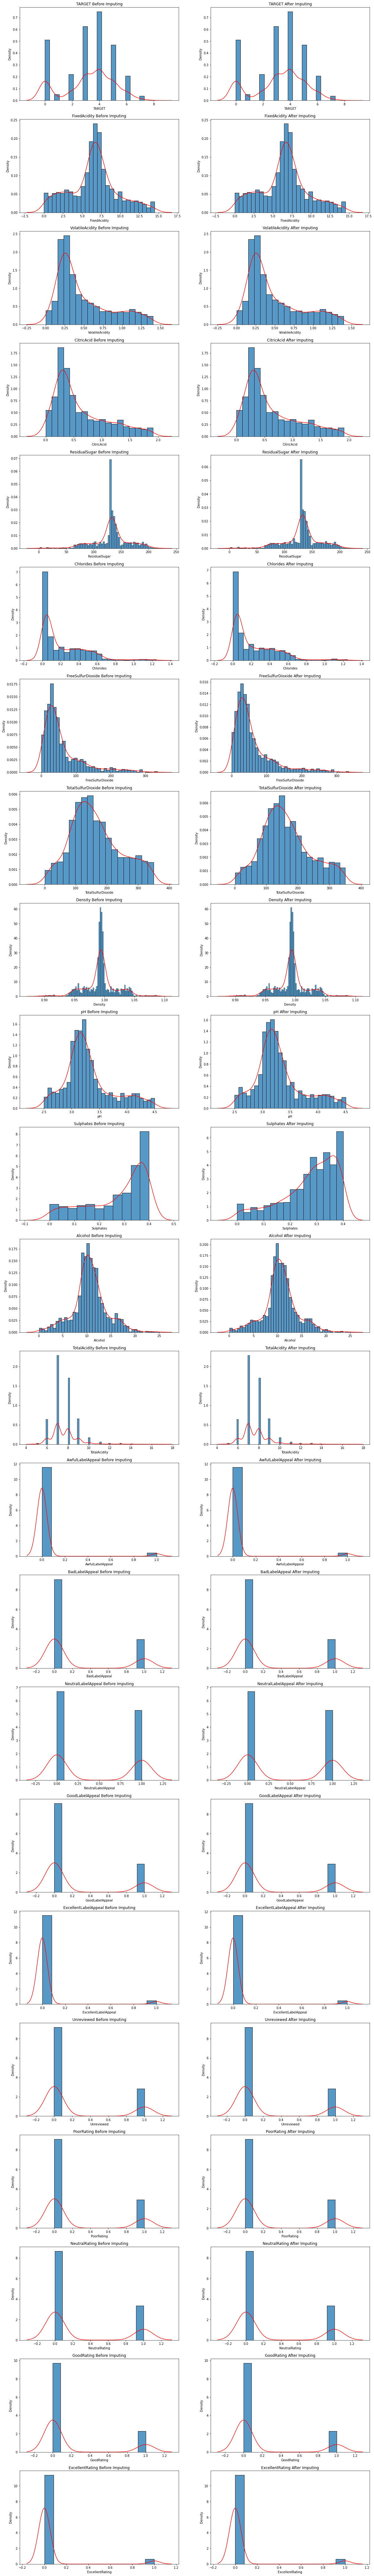

In [414]:
fig, axes = plt.subplots(23, 2, figsize=(20,150))

x = 0
y = 0
for column in wine_with_dummies.columns:
  sns.histplot(wine_with_dummies[column], ax=axes[x, y], stat='density')
  sns.kdeplot(wine_with_dummies[column], ax=axes[x, y], color='red', alpha=0.5)
  axes[x, y].set_title(column + " Before Imputing")
  x = x + 1 if y == 1 else x
  y = y + 1 if y == 0 else 0

  sns.histplot(wine_with_dummies_imputed[column], ax=axes[x, y], stat='density')
  sns.kdeplot(wine_with_dummies_imputed[column], ax=axes[x, y], color='red', alpha=0.5)
  axes[x, y].set_title(column + " After Imputing")
  x = x + 1 if y == 1 else x
  y = y + 1 if y == 0 else 0

plt.show()

As you can see, our distributions remain unchanged after imputing values using the K-nearest neighbor technique

### __Reset DataFrame With Imputed Data__

Now that we know our distribution remains unchanged, we're going to set our original data frame to our imputed data frame

In [415]:
wine_with_dummies = wine_with_dummies_imputed.copy()

wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
0,4.0,9.0,0.22,0.49,138.2,0.150,33.2,195.0,1.05918,3.01,0.400,10.2,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,0.232,6.8,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.400,15.2,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,0.360,16.6,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.210,9.8,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [416]:
wine_with_dummies.shape

(1393, 23)

## __4. Re-Run EDA__

Now that we have a useable dataset, let's re-run the EDA and compare it to our original EDA.

In [430]:
wine_data.head()

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0


In [431]:
wine_with_dummies.head()

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,TotalAcidity,AwfulLabelAppeal,BadLabelAppeal,NeutralLabelAppeal,GoodLabelAppeal,ExcellentLabelAppeal,Unreviewed,PoorRating,NeutralRating,GoodRating,ExcellentRating
0,4.0,9.0,0.22,0.49,138.2,0.150,33.2,195.0,1.05918,3.01,0.400,10.2,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,5.7,0.50,0.11,133.9,0.071,234.0,331.0,0.99780,3.35,0.232,6.8,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,2.7,1.02,0.53,83.8,0.174,60.0,72.0,0.99519,3.18,0.400,15.2,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.0,8.0,0.01,1.10,172.6,0.350,17.0,129.0,1.03564,3.20,0.360,16.6,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,5.7,0.25,0.27,138.6,0.050,58.0,243.0,0.95643,3.10,0.210,9.8,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [433]:
print("original shape: " + str(wine_data.shape))
print("new shape: " + str(wine_with_dummies.shape))

original shape: (12795, 16)
new shape: (1393, 23)


As you can see, our dataset has been trimmed down significantly, from 12,795 to 1,393. This is the result of all the innacurrate and impossible data that we had to drop from our dataset

### Negatives

In [419]:
# original negatives
negatives = wine_data.where(wine_data<0).count()
negatives

INDEX                    0
TARGET                   0
FixedAcidity          1621
VolatileAcidity       2827
CitricAcid            2966
ResidualSugar         3136
Chlorides             3197
FreeSulfurDioxide     3036
TotalSulfurDioxide    2504
Density                  0
pH                       0
Sulphates             2361
Alcohol                118
LabelAppeal           3640
AcidIndex                0
STARS                    0
dtype: int64

In [418]:
# new negatives
wine_with_dummies.where(wine_with_dummies<0).count()

TARGET                  0
FixedAcidity            0
VolatileAcidity         0
CitricAcid              0
ResidualSugar           0
Chlorides               0
FreeSulfurDioxide       0
TotalSulfurDioxide      0
Density                 0
pH                      0
Sulphates               0
Alcohol                 0
TotalAcidity            0
AwfulLabelAppeal        0
BadLabelAppeal          0
NeutralLabelAppeal      0
GoodLabelAppeal         0
ExcellentLabelAppeal    0
Unreviewed              0
PoorRating              0
NeutralRating           0
GoodRating              0
ExcellentRating         0
dtype: int64

We've eliminated all negative values by transforming them either by adding a constant to shift the data or by converting them to their absolute values.

### Nulls

In [421]:
# old null values
wine_data.isnull().sum()

INDEX                    0
TARGET                   0
FixedAcidity             0
VolatileAcidity          0
CitricAcid               0
ResidualSugar          616
Chlorides              638
FreeSulfurDioxide      647
TotalSulfurDioxide     682
Density                  0
pH                     395
Sulphates             1210
Alcohol                653
LabelAppeal              0
AcidIndex                0
STARS                 3359
dtype: int64

In [420]:
# new null values
wine_with_dummies.isnull().sum()

TARGET                  0
FixedAcidity            0
VolatileAcidity         0
CitricAcid              0
ResidualSugar           0
Chlorides               0
FreeSulfurDioxide       0
TotalSulfurDioxide      0
Density                 0
pH                      0
Sulphates               0
Alcohol                 0
TotalAcidity            0
AwfulLabelAppeal        0
BadLabelAppeal          0
NeutralLabelAppeal      0
GoodLabelAppeal         0
ExcellentLabelAppeal    0
Unreviewed              0
PoorRating              0
NeutralRating           0
GoodRating              0
ExcellentRating         0
dtype: int64

We've also eliminated all null values by using sci-kit learn's KNN Imputer

### Distribution

Now, let's take a look at the distribution of our original data set and compare it to our final data set

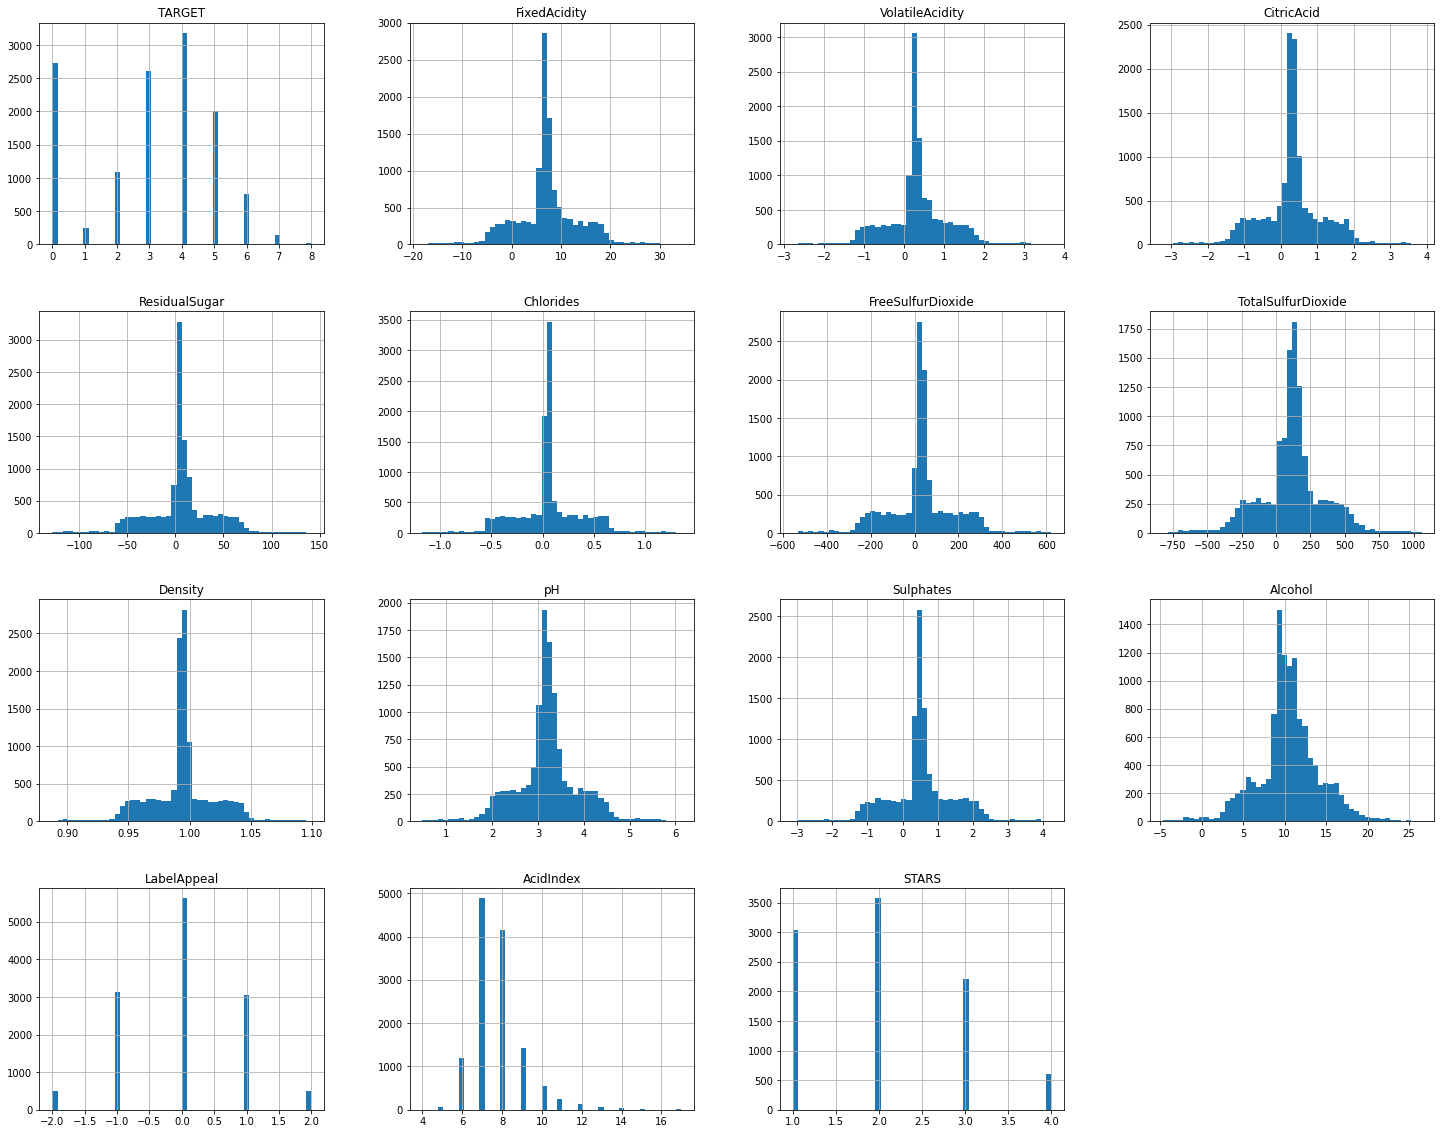

In [422]:
# old distribution
wine_data.iloc[:,1:].hist(bins=50, figsize=(25, 20))
plt.show()

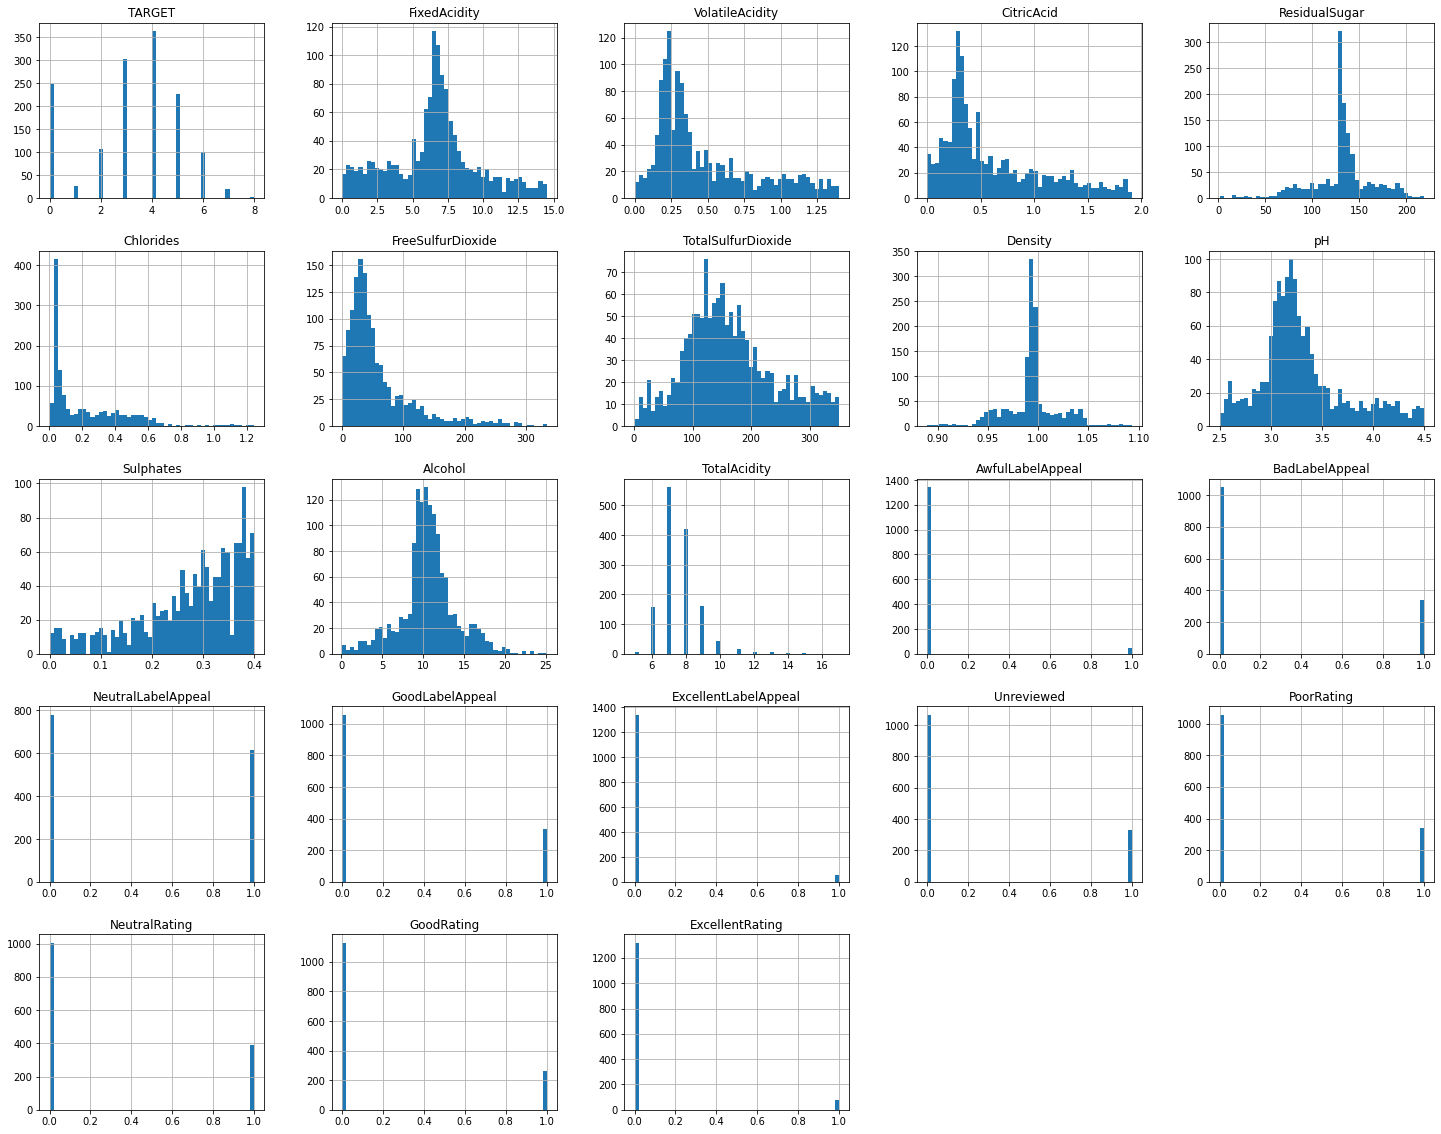

In [424]:
# new distribution
wine_with_dummies.hist(bins=50, figsize=(25, 20))
plt.show()

__Takeaways:__

- The distributions for TARGET, FixedAcidity, ResidualSugar, Density, Alcohol, and TotalAcidity (AcidIndex in original) remain largely unchanged.
- The distributions of VolatileAcidity, CitricAcid, Chlorides, FreeSulfurDioxide, TotalSulfurDioxide, and pH all changed from a normal distribution to a right-skewed normal distribution
- Sulphates changed from a normal distribution to a left-skewed normal distribution

### Correlation

Now, let's compare the correlation of our new dataset vs our original dataset

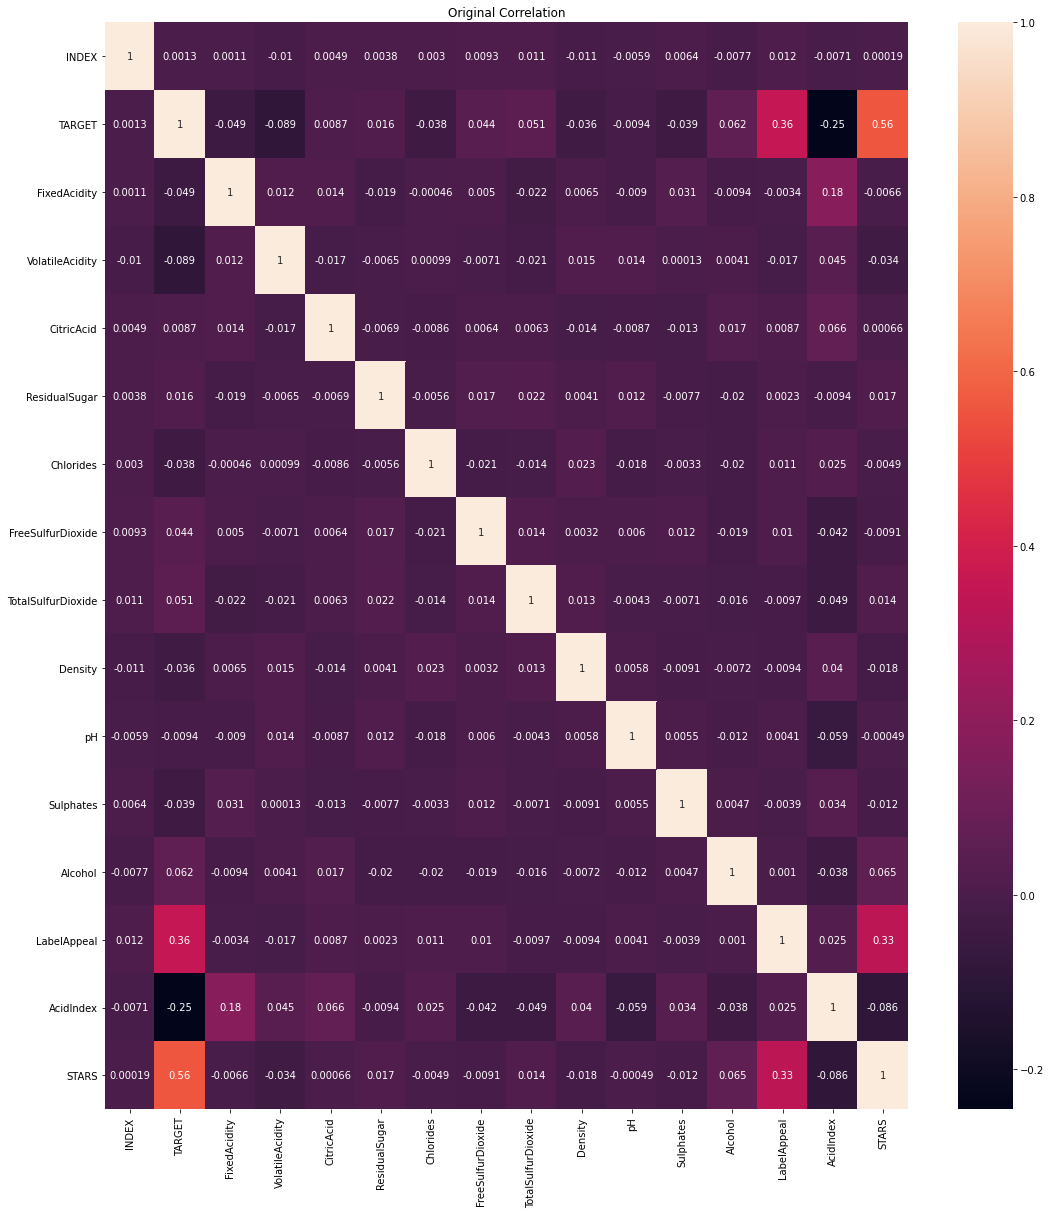

In [434]:
# original data
cor = wine_data.corr()
plt.figure(figsize=(18, 20))
plt.title("Original Correlation")
sns.heatmap(cor, annot=True)
plt.show()

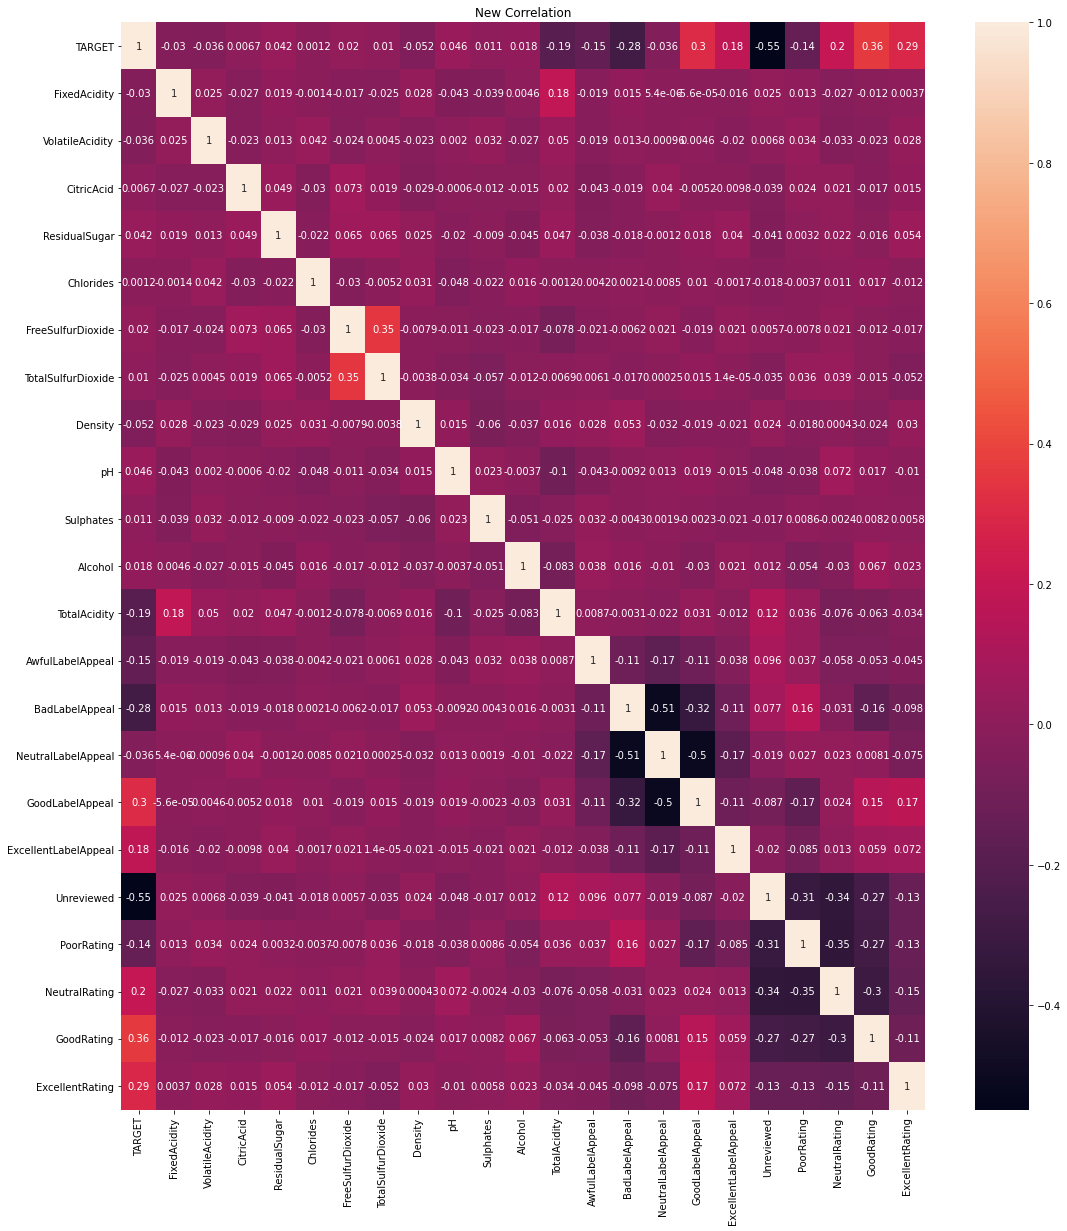

In [428]:
# new data
new_cor = wine_with_dummies.corr()
plt.figure(figsize=(18, 20))
plt.title("New Correlation")
sns.heatmap(new_cor, annot=True)
plt.show()

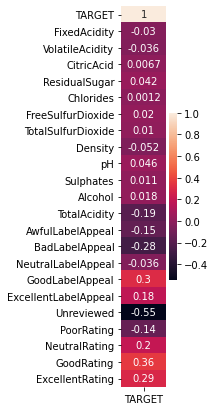

In [429]:
# set figure
plt.figure(figsize=(1, 7))

# Get correlation numbers just for response variable
target_cor = new_cor[['TARGET']]
sns.heatmap(target_cor, annot=True)
plt.show()

We still don't have any strong correlations. Our strongest correlation is definitely with the ratings. We see a relatively strong negative correlation between TARGET and Unreviewed, telling us that we don't sell a lot of cases of unreviewed wines. We also see a solid positive correlation between TARGET and GoodRating and ExcellentRating. This tells us that we tend to sell more cases of highly rated wines. LabelAppeal also has a decent correlation

## __5. Conclusion__

- This was a very messy data set. There were many impossible data entries, there were many improbable data entries, and there were many missing data entries.

- We got rid of the impossible negatives by converting them to positive values, either by adding a constant to shift the data or converting them to their absolute values. We got rid of the impossible/improbable outliers by using our domain expertise to identify and remove any observations that didn't make sense.

- We used a KNN Imputer to fill the missing data based on other observations that were similar to the one with the missing data. For this we had to normalize our data to avoid introducing bias to our imputer.

- After imputing, we reversed the normalization and updated our dataset.

- We then compared the results of our data cleaning to our original data set.

- After all the cleaning, we truncated our dataset down from 12,795 observations to 1,393.

- Although this dataset is now prepared for use in a machine learning model I would caution against using it given the numerous inaccuracies and impossibilities in the data. I removed all the impossible data points, but I can't vouch for the accuracy of the rest of the data.